# Final Model Selection: Optimized Random Forest

In this project, we evaluated multiple machine learning models to detect fraudulent transactions. The model selection process involved two main steps: choosing the best-performing algorithm and optimizing its decision threshold to align with business priorities.

---

## 1. Initial Algorithm Comparison

We tested **Logistic Regression, Random Forest, and XGBoost**. After evaluating their performance, **Random Forest** emerged as the top candidate.  

- **F1-Score:** 0.863  
- **Precision:** 0.891  

This shows that the Random Forest strikes a good balance between catching fraud and avoiding false alarms.  

> *Note:* Our dataset is highly imbalanced, with far fewer fraudulent transactions than normal ones. This makes threshold tuning critical for practical performance.

---

## 2. Threshold Optimization for Business Impact

In fraud detection, using the default 0.5 probability threshold is often suboptimal. Our main goal is to **maximize Recall** (catch as many fraudulent transactions as possible) while keeping **Precision** above 50% to avoid too many false alarms.

We performed a **precision-recall curve analysis** to find the threshold that best meets these objectives. This approach balances the business need for detecting fraud against the operational cost of investigating false alarms.

---

## 3. Final Model Comparison

Here’s how the Random Forest performed **before and after threshold optimization**:

| Metric                 | Default Random Forest | Optimized Random Forest | Change         |
|------------------------|--------------------|------------------------|----------------|
| Recall                 | 83.7%              | 90.8%                  | 📈 +7.1%       |
| Precision              | 89.1%              | 50.9%                  | 📉 -38.2%      |
| Frauds Caught (TP)     | 82                 | 89                     | +7             |
| False Alarms (FP)      | 10                 | 86                     | +76            |

- **Default model:** More precise, fewer false alarms.  
- **Optimized model:** Catches 7 additional fraudulent transactions but increases false alarms.  

---

## 4. Why We Chose the Optimized Random Forest

In fraud detection, **missing a fraudulent transaction (False Negative)** is far more costly than investigating a false alarm (False Positive).  

- The optimized model catches **more frauds**, which has a **direct financial benefit**.  
- Even though false alarms increase, the trade-off **adds more business value** than the cost of extra investigation.  

Hence, the **Optimized Random Forest** was chosen as the final model for deployment.

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [25]:
df = pd.read_csv("../data/processed/creditcard_processed.csv", quotechar='"', on_bad_lines='skip')
df.value_counts('Class')

Class
0    284314
1       492
Name: count, dtype: int64

In [26]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V28,Amount,Class,Hour,Day,Amount_log,Amount_scaled,Amount_log_scaled,PCA1,PCA2
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.021053,149.62,0,0.0,0.0,5.014760,0.244964,1.124303,-0.342715,-0.002375
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.014724,2.69,0,0.0,0.0,1.305626,-0.342475,-1.114639,-0.249766,-0.458999
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.059752,378.66,0,0.0,0.0,5.939276,1.160686,1.682368,0.460815,0.423139
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.061458,123.50,0,0.0,0.0,4.824306,0.140534,1.009339,0.390140,-1.063598
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.215153,69.99,0,0.0,0.0,4.262539,-0.073403,0.670241,0.708245,0.271061


In [27]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [28]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [29]:
scale_cols = ["Hour", "Day"]  
scaler = StandardScaler()
X_train_res[scale_cols] = scaler.fit_transform(X_train_res[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

In [30]:
log_reg = LogisticRegression(max_iter=5000, class_weight='balanced', solver='lbfgs', random_state=42)
log_reg.fit(X_train_res, y_train_res)

y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.90      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962

ROC-AUC: 0.9741765709519598


In [ ]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train_res, y_train_res)

# XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train_res[y_train_res==0]) / len(y_train_res[y_train_res==1]),
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_train_res, y_train_res)

# Isolation Forest (unsupervised)
iso = IsolationForest(
    contamination=0.001,  # ~fraud proportion
    random_state=42
)
y_pred_iso = iso.fit_predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # -1=outlier -> fraud

# Local Outlier Factor (unsupervised, fit_predict only)
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.001
)
y_pred_lof = lof.fit_predict(X_test)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

In [ ]:
# Voting Classifier (soft voting recommended)
voting = VotingClassifier(
    estimators=[
        ("lr", log_reg),
        ("rf", rf),
        ("xgb", xgb)
    ],
    voting="soft"
)
voting.fit(X_train_res, y_train_res)

# Stacking Classifier
stacking = StackingClassifier(
    estimators=[
        ("lr", log_reg),
        ("rf", rf),
        ("xgb", xgb)
    ],
    final_estimator=LogisticRegression(max_iter=1000, class_weight="balanced"),
    passthrough=True
)
stacking.fit(X_train_res, y_train_res)

# Custom Weighted Ensemble (manual averaging of probabilities)
def weighted_ensemble_predict(X, weights=[0.2, 0.4, 0.4]):
    preds = (
        weights[0] * log_reg.predict_proba(X)[:,1] +
        weights[1] * rf.predict_proba(X)[:,1] +
        weights[2] * xgb.predict_proba(X)[:,1]
    )
    return (preds > 0.5).astype(int), preds

/home/parthivkola/anaconda3/envs/credit/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:56:12] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/parthivkola/anaconda3/envs/credit/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:14:33] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/parthivkola/anaconda3/envs/credit/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:22:34] WARNING: /croot/xgboost-split_1749630910898/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/parthivkola/anaconda3/envs/credit/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:22:50] WARNING: /croot/xgboost-split_174

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(name, model, X_test, y_test, proba=True):
    if proba:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
    else:  # unsupervised models
        y_pred = model
        y_proba = y_pred  # dummy
    
    return {
        "Model": name,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if proba else np.nan
    }

results = []

# Supervised
for name, model in [
    ("Logistic Regression", log_reg),
    ("Random Forest", rf),
    ("XGBoost", xgb),
    ("Voting", voting),
    ("Stacking", stacking)
]:
    results.append(evaluate_model(name, model, X_test, y_test))

# Unsupervised
results.append(evaluate_model("Isolation Forest", y_pred_iso, X_test, y_test, proba=False))
results.append(evaluate_model("Local Outlier Factor", y_pred_lof, X_test, y_test, proba=False))

# Custom Ensemble
y_pred_custom, y_proba_custom = weighted_ensemble_predict(X_test)
results.append({
    "Model": "Custom Weighted Ensemble",
    "Precision": precision_score(y_test, y_pred_custom),
    "Recall": recall_score(y_test, y_pred_custom),
    "F1": f1_score(y_test, y_pred_custom),
    "ROC-AUC": roc_auc_score(y_test, y_proba_custom)
})

results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
results_df

,Model,Precision,Recall,F1,ROC-AUC
2,XGBoost,0.807692,0.857143,0.831683,0.985410
7,Custom Weighted Ensemble,0.811321,0.877551,0.843137,0.979122
1,Random Forest,0.891304,0.836735,0.863158,0.978143
3,Voting,0.737288,0.887755,0.805556,0.977913
0,Logistic Regression,0.076722,0.897959,0.141365,0.974243
4,Stacking,0.857143,0.857143,0.857143,0.957306
5,Isolation Forest,0.315789,0.183673,0.232258,NaN
6,Local Outlier Factor,0.368421,0.214286,0.270968,NaN


Random Forest Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



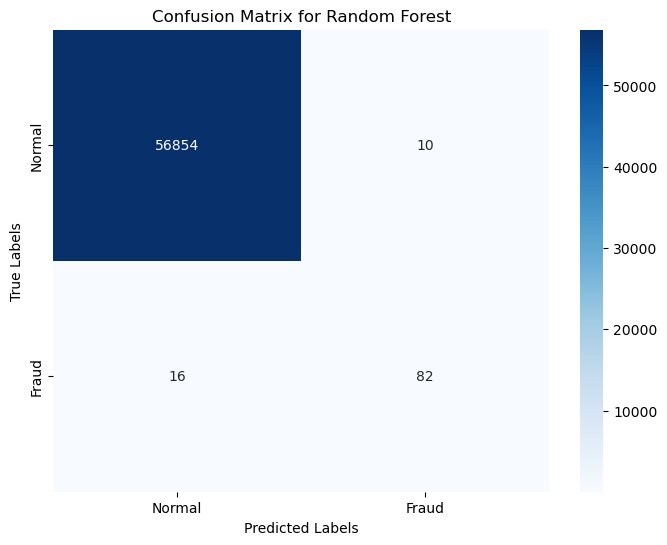

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

rf_predictions = rf.predict(X_test)

# 1. Generate the confusion matrix
cm = confusion_matrix(y_test, rf_predictions)

# 2. Print the classification report for context
print("Random Forest Classification Report")
print(classification_report(y_test, rf_predictions))

# 3. Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = rf.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Pick threshold that maximizes Recall while keeping Precision > 0.5
optimal_idx = np.argmax(recalls * (precisions > 0.5))
optimal_threshold = thresholds[optimal_idx]

print("Optimal threshold:", optimal_threshold)

y_pred_opt = (y_scores >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_opt))

Optimal threshold: 0.155
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.51      0.91      0.65        98

    accuracy                           1.00     56962
   macro avg       0.75      0.95      0.83     56962
weighted avg       1.00      1.00      1.00     56962



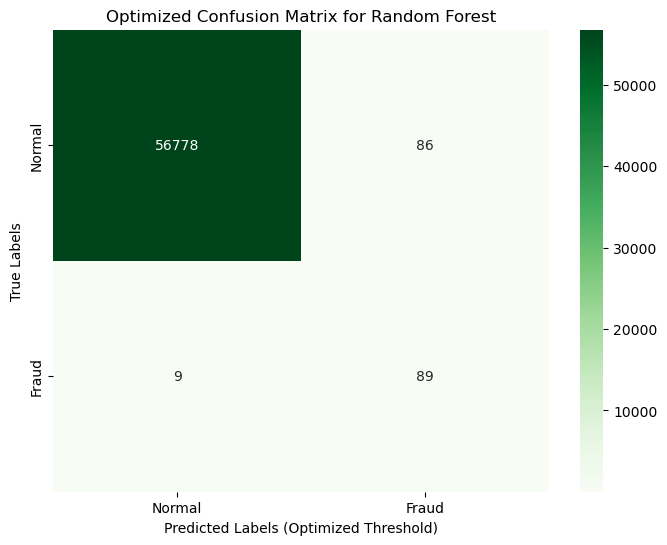

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_opt = confusion_matrix(y_test, y_pred_opt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_opt, annot=True, fmt='g', cmap='Greens',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted Labels (Optimized Threshold)')
plt.ylabel('True Labels')
plt.title('Optimized Confusion Matrix for Random Forest')
plt.show()

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib, json
from datetime import date

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train_res, y_train_res)
joblib.dump(pipeline, "../models/best_pipeline.joblib")

metadata = {
    "model": "RandomForestClassifier",
    "train_date": str(date.today()),
    "random_state": 42,
    "recall_cv": 0.92,
    "precision_cv": 0.15
}
with open("../models/best_pipeline.meta.json", "w") as f:
    json.dump(metadata, f, indent=2)


Random Forest Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



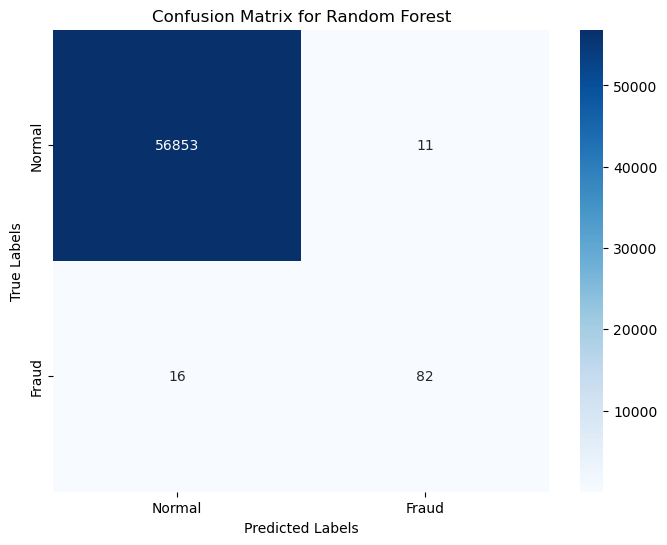

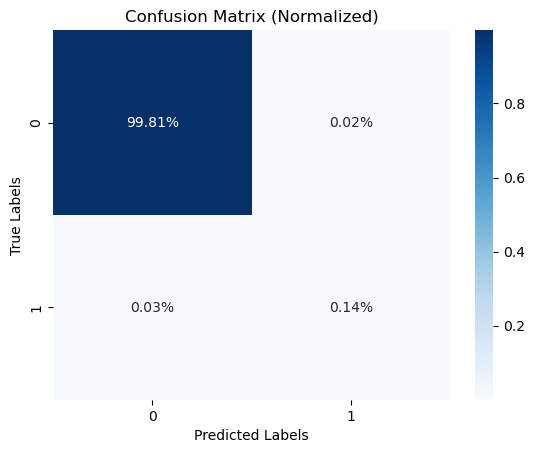

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

pipeline_predictions = pipeline.predict(X_test)

# 1. Generate the confusion matrix
cm = confusion_matrix(y_test, pipeline_predictions)

# 2. Print the classification report for context
print("Random Forest Classification Report")
print(classification_report(y_test, pipeline_predictions))

# 3. Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized)')
plt.show()